# Lesson 6: anomalies vs breaks
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: GOSIF**

**Application: agricultural drought in Rajasthan, India**

**Solar-Induced Chlorophyll Fluorescence (SIF)** is a very faint light emitted by chlorophyll molecules in plants during photosynthesis. When chlorophyll absorbs sunlight (photosynthetically active radiation, or PAR), a small fraction (about 1–2%) of the absorbed light is re-emitted at longer wavelengths (mainly in the red and near-infrared) — this is chlorophyll fluorescence. When this emission happens under natural sunlight, it is called solar-induced chlorophyll fluorescence (SIF). At canopy or landscape scales, SIF integrates the fluorescence emitted by all leaves in the field of view, providing a measure of gross photosynthetic activity (GPP) over large areas.

Satellites (such as GOSAT, OCO-2, TROPOMI, or TanSat) detect this weak fluorescence signal by exploiting Fraunhofer lines, which is narrow dark absorption lines in the solar spectrum, to distinguish SIF from reflected sunlight.

Rajasthan is one of the most drought-prone states in India, characterized by low rainfall, hot and dry climate and arid regions. The past study reveals that the severe drought occurs in this region between 2020 and 2022 [1]. The drought constrains photosynthetic activity and chlorophyll excitation efficiency in plants, thereby causing a decreasing signal in SIF. 

In this lesson, we will use S-CCD to capture the drought signal from a SIF-based time series. We will use GOSIF dataset [2], which is a widely used SIF product providing the most frequent observation (8-day).

*[1] Nathawat, R., Singh, S. K., Sajan, B., Pareek, M., Kanga, S., Đurin, B., ... & Rathnayake, U. (2025). Integrating Cloud-Based Geospatial Analysis for Understanding Spatio-Temporal Drought Dynamics and Microclimate Variability in Rajasthan: Implications for Urban Development Planning. Journal of the Indian Society of Remote Sensing, 1-23.*

*[2] Li, X., & Xiao, J. (2019). A global, 0.05-degree product of solar-induced chlorophyll fluorescence derived from OCO-2, MODIS, and reanalysis data. Remote Sensing, 11(5), 517.*

---

## Detecting disturbances using "break"

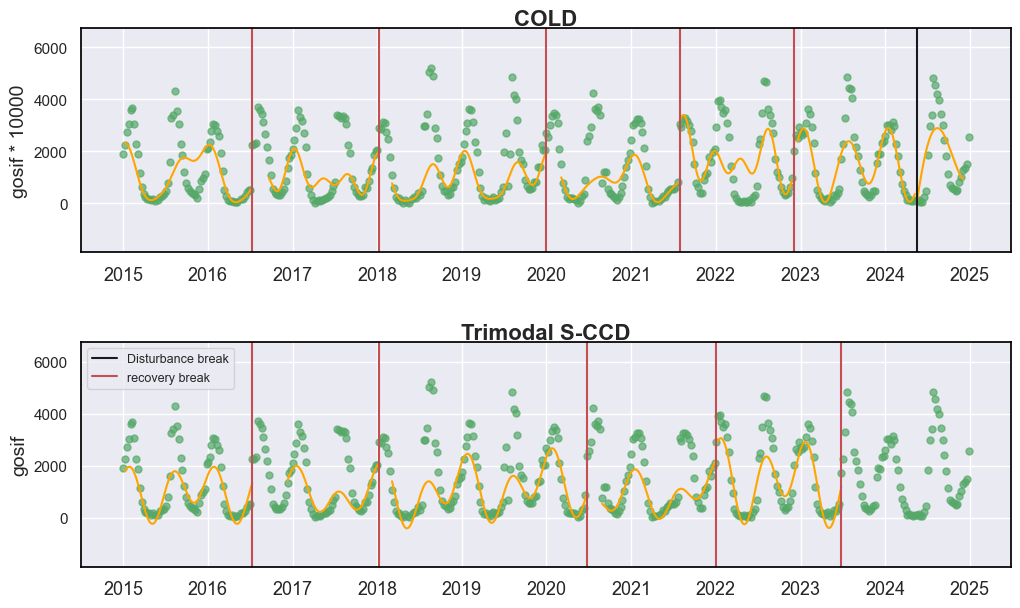

In [1]:
import pandas as pd
import numpy as np
import pathlib
from dateutil import parser
import pathlib
from datetime import date
from typing import List, Tuple, Dict, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from pyxccd import sccd_detect_flex, cold_detect_flex
from pyxccd.common import SccdOutput, cold_rec_cg, anomaly
from pyxccd.utils import getcategory_sccd, defaults, getcategory_cold, predict_ref

def display_cold_result_sif(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    cold_result: cold_rec_cg,
    axe: Axes,
    title: str = 'COLD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD algorithms,
    and visualizes the curve fitting and break detection results. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "COLD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])

    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0][band_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot COLD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot COLD segments
    for segment in cold_result:
        j = np.arange(segment['t_start'], segment['t_end'] + 1, 1)
        plot_df = pd.DataFrame({
            'dates': j,
            'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
            'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
            'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
            'trimodel': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index ][7]
        })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual'] + 
            plot_df['trimodel']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # add break lines
    for i in range(len(cold_result)):
        if  cold_result[i]['change_prob'] == 100:
            # we used the sign of change magnitude to decide the category of the breaks
            if cold_result[i]['magnitude'] < 0:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='k')
            else:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])
    

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)
    


def display_sccd_result_single(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    states:Optional[pd.DataFrame] = None,
    trimodal: bool = False,
    anomaly:Optional[anomaly] = None,
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
    
    states: pd.Dataframe
        S-CCD state outputs
        
    trimodal: bool
        indicate whether using trimodal
    
    anomaly: anomaly, optional
        The anomaly detection outputs
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    if trimodal:
        n_coefs = 8
    else:
        n_coefs = 6
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    if states is not None:
        if trimodal is True:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']+states['b0_trimodal']
        else:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
        states.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=states,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()
    else:
        for segment in sccd_result.rec_cg:
            j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': j * 0
                })

            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
                })
            
            plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
            # Convert dates and plot model fit
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()

        # Plot near-real-time projection for SCCD if available
        if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
            recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
            j = np.arange(
                sccd_result.nrt_model['t_start_since1982'].item() + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
                recent_obs[-1].item()+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
                1
            )

            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
                })
            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': j * 0
                })
                
            plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()
            
    # add manual legends
    if anomaly is not None:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                            Line2D([0], [0], label='recovery break', color='r'),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="black",
                            label='Disturbance anomalies', lw=0, markersize=8),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="red",
                            label='Recovery anomalies', lw=0, markersize=8)]
    else:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                    Line2D([0], [0], label='recovery break', color='r')]
    axe.legend(handles=legend_elements, loc='upper left', prop={'size': 9})
    
    # plot breaks
    for i in range(len(sccd_result.rec_cg)):
        # we used the sign of change magnitude to decide the category of the breaks
        if sccd_result.rec_cg[i]['magnitude'] < 0:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
   
    
    # plot anomalies if available
    if anomaly is not None:
        for i in range(len(anomaly.rec_cg_anomaly)):
            pred_ref = np.asarray(
                    [
                        predict_ref(
                            anomaly.rec_cg_anomaly[i]["coefs"][0],
                            anomaly.rec_cg_anomaly[i]["obs_date_since1982"][i_conse].item()
                            + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], num_coefficients=n_coefs
                        ) for i_conse in range(3)
                    ]
            )

            cm = anomaly.rec_cg_anomaly[i]["obs"][0, 0: 3] - pred_ref
            
            # gpp increase is black line
            if np.median(cm) > 0:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ro',fillstyle='none',markersize=8)         
            # gpp decrease is red line
            else:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ko',fillstyle='none',markersize=8) 
        
    axe.set_ylabel(f"{band_name}", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)


TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()

in_path = TUTORIAL_DATASET/ '6_drought_gosif_india.csv' # read single-pixel MODIS time series


# read example csv for HLS time series
data = pd.read_csv(in_path)

# let's focus on the data after 2013
data = data[data['dates'] > pd.Timestamp.toordinal(parser.parse("2014-12-30"))]


# as the original data doesn't have qa, we append qa as all zeros value (meaning they are all clear)
data['qa'] = np.zeros(data.shape[0])
dates, sif, qas = data.to_numpy().astype(np.int64).copy().T

# we applied trimodal SCCD
sccd_result = sccd_detect_flex(dates, sif, qas, trimodal=True, lam=20, fitting_coefs=True)
cold_result = cold_detect_flex(dates, sif, qas,  lam=20)

# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_cold_result_sif(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, cold_result=cold_result, axe=axes[0])

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result, axe=axes[1], trimodal=True, title="Trimodal S-CCD")

# display_sccd_states_flex(data_df=data[(data['GOSIF'] >= 0)],  states=states, axes=axes, variable_name="GOSIF", title="S-CCD")


From the figure, it can be observed that both the COLD and S-CCD algorithms yielded somewhat different results. However, both methods failed to capture drought-related breaks during 2020 and 2022 reported by the previous study. This omission is likely because the coarse spatial resolution of the dataset tends to smooth the temporal signal, thereby diminishing the magnitude of short-term fluctuations and reducing the statistical significance of drought-induced changes.

## Increasing the sensitivity for detecting breaks
Let's try using an aggressive parameter setting (p_cg=0.9; conse=3) for break detection:

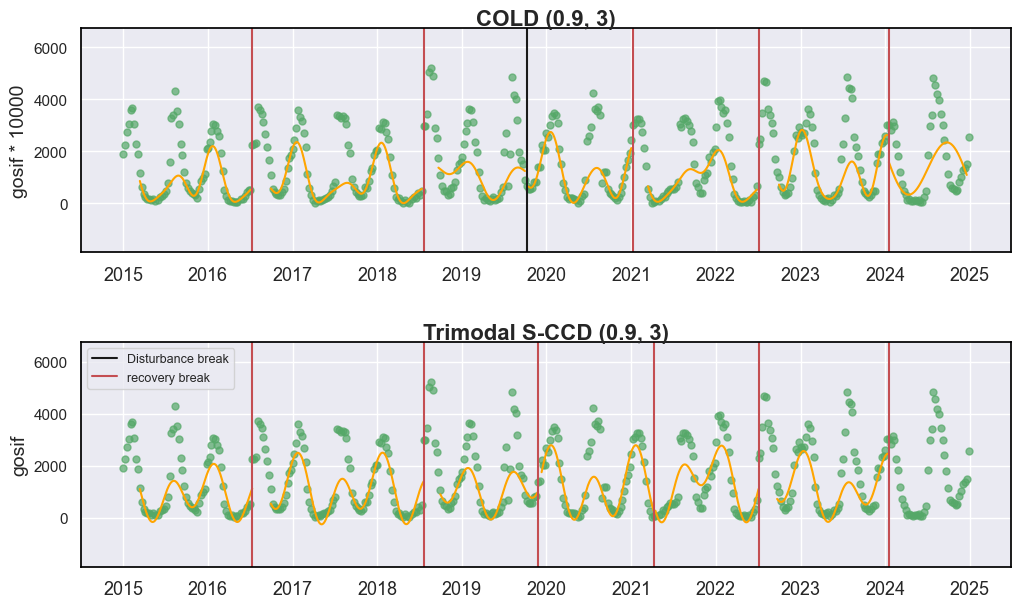

In [2]:
# we applied an aggressive parameter set
sccd_result = sccd_detect_flex(dates, sif, qas, p_cg=0.9, conse=3, trimodal=True, lam=20, fitting_coefs=True)
cold_result = cold_detect_flex(dates, sif, qas,  p_cg=0.9, conse=3, lam=20)

# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_cold_result_sif(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, cold_result=cold_result, axe=axes[0], title="COLD (0.9, 3)")

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result, axe=axes[1], trimodal=True, title="Trimodal S-CCD (0.9, 3)")

Now, we could find more breaks detected by both algorithms. However, most of them are attributed to recovery (i.e., gosif increase).

Although frequent “break” detections might appear desirable for capturing rapid changes, this is **not necessarily advantageous for CCDC-like algorithms**. Excessive break detection triggers frequent model re-initialization, which introduces a monitoring gap of at least one year and thereby limits the ability to detect successive disturbances. Furthermore, the shortened observation period for each segment reduces the robustness and accuracy of model fitting. Frequent re-initialization also complicates near-real-time (NRT) monitoring, as the lack of a stable model within new segments disrupts temporal continuity. Nonetheless, re-initialization remains necessary in practice, since structural changes associated with substantial land cover transformations introduce large uncertainties in the model coefficients, necessitating model recalibration.

## Solution: "anomaly-break" detection hierachy

To address this issue, S-CCD allows employing a **two-level hierarchical framework** that distinguishes between anomalies and breaks. Anomalies refer to observations that deviate from the model predictions within a relatively short temporal window and with smaller magnitude thresholds. In contrast, breaks represent clusters of anomalies characterized by large deviations and extended durations, indicating a structural change in the time series. When anomalies are detected, S-CCD take records of key parameters (e.g., t_break, harmonic coefficients, change magnitudes), but it does not re-initialize the model. Only when a break is confirmed does S-CCD perform model re-initialization.

| Name| Definition | Default parameters | Re-initialization | Usage |
| :------- | :------: | -------: | -------: | -------: |
| Anomalies | Observations that deviate from the predicted  | `p_cg=0.9`, `conse=3` | No | `output_anomaly=True` |
| Breaks | Observations that cause structural changes   | `p_cg=0.99`, `conse=6`  | Yes | `output_anomaly=False` |



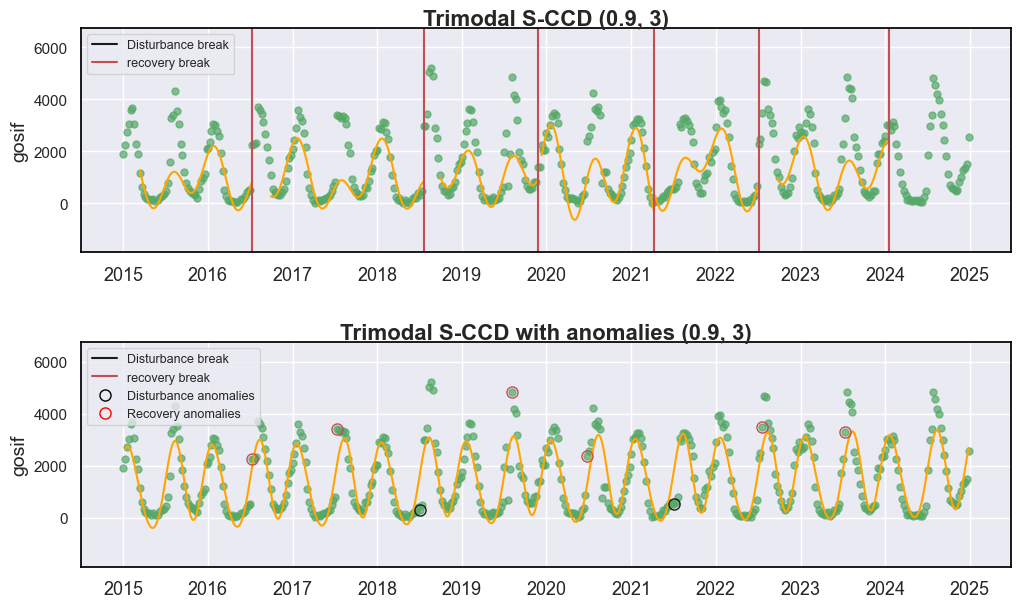

In [3]:
sccd_result1 = sccd_detect_flex(dates, sif, qas,  p_cg=0.9, conse=3, trimodal=True, lam=20)

# we turned on the anomaly output
sccd_result2, anomaly = sccd_detect_flex(dates, sif, qas, p_cg = 0.9999, conse=8, output_anomaly=True, trimodal=True, lam=20, fitting_coefs=True)


# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result1, axe=axes[0], trimodal=True, title="Trimodal S-CCD (0.9, 3)")

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result2, axe=axes[1], trimodal=True, anomaly=anomaly, title="Trimodal S-CCD with anomalies (0.9, 3)")

The anomalies detected were highlighted as circle in the above. We found that it has moderate descripancy with the breaks detected using the same parameter settings (`conse=3`, `p_cg=0.9`), which proves that **the frequent initialization definitely could affect the break detection**. The anomalies provides more accurate detection, for example, the significant drop in 2021 has been captured by `Trimodal S-CCD with anomalies (0.9, 3)`, but missed in `Trimodal S-CCD (0.9, 3)` which relies on only break detection, instead of "anomaly-break" detection hierachy.

The output `anomaly` stores rich information for every anomalies being detected, which could be used for machine learning and further taken for near real-time disturbance monitoring [3] 

[3] Ye, S., Zhu, Z., & Suh, J. W. (2024). Leveraging past information and machine learning to accelerate land disturbance monitoring. Remote Sensing of Environment, 305, 114071.

In [4]:
print(anomaly)

SccdReccganomaly(position=1, rec_cg_anomaly=array([(736156, [[ 5.1858328e+04, -6.9177362e+02,  3.3654770e+02, -1.7499992e+01,  9.5840057e+02,  8.6213184e+02,  5.0908569e+02, -8.8351173e+01]], [[2246, 2269, 2317, 3703, 3604, 3441, 3108, 2656]], [12414, 12422, 12430, 12438, 12446, 12454, 12462, 12470], [2045, 1376,  866,  866,  866,  866,  866,  619], [    0,     0,     0,     0,     0,     0,     0,     0]),
       (736522, [[-9.6152391e+04,  1.3227594e+03,  2.4489276e+02, -2.7984451e+02,  9.8913678e+02,  9.1183948e+02,  4.3716653e+02, -1.6476933e+02]], [[3405, 3365, 3288, 3343, 3275, 3053, 2240, 1924]], [12780, 12788, 12796, 12804, 12812, 12820, 12828, 12836], [2350, 1521,  834,  529,  261,   69,   69,   69], [    0,     0,     0,     0,     0,     0,  3000,  2571]),
       (736879, [[-6.8156734e+04,  9.4231702e+02,  2.4477156e+02, -3.1494083e+02,  1.0485380e+03,  8.3385455e+02,  3.3004968e+02, -2.2306662e+02]], [[ 308,  483, 2969, 2970, 3449, 5039, 5201, 4901]], [13137, 13145, 13153, 

S-CCD also allows users to define the anomalies by adjusting `anomaly_conse` and `anomaly_pcg`:

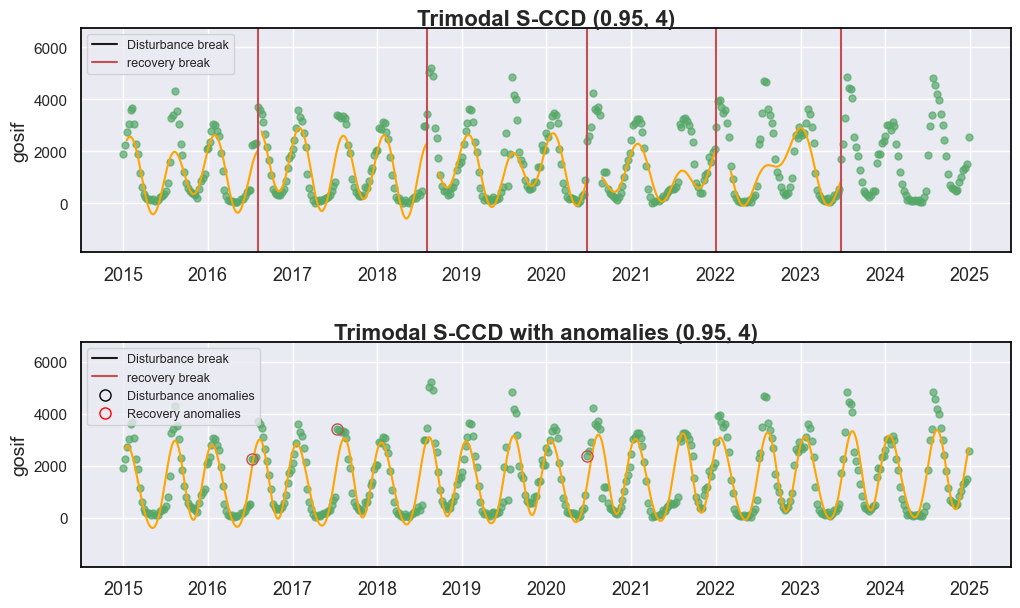

In [5]:
sccd_result1 = sccd_detect_flex(dates, sif, qas,  p_cg=0.95, conse=4, lam=20)
sccd_result2, anomaly = sccd_detect_flex(dates, sif, qas, anomaly_conse=4, anomaly_pcg=0.95, p_cg = 0.9999, output_anomaly=True, trimodal=True, lam=20, fitting_coefs=True)


# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result1, axe=axes[0], trimodal=True, title="Trimodal S-CCD (0.95, 4)")

display_sccd_result_single(data=data[(data['GOSIF'] >= 0)].to_numpy(), band_names=['gosif'], band_index=0, sccd_result=sccd_result2, axe=axes[1], anomaly=anomaly, trimodal=True, title="Trimodal S-CCD with anomalies (0.95, 4)")

Now you could see the drought detected in the "Trimodal S-CCD with anomalies (0.90, 3)" were all gone in "Trimodal S-CCD with anomalies (0.95, 4)"

It is worth noting that S-CCD is primarily designed to detect greening or browning anomalies in vegetation time series, rather than to attribute these anomalies to specific causal factors. The identified anomalies represent significant deviations from the predicted temporal trajectory, but they are not necessarily indicative of drought-induced stress. Such vegetation changes could also arise from other drivers, including land-use transitions, pest outbreaks, or climatic fluctuations unrelated to water availability. Therefore, to confirm whether the detected anomalies are indeed drought-driven, it is recommended to **integrate the analysis with an independent Standardized Precipitation Evapotranspiration Index (SPEI) time series**. This complementary assessment can help establish a more direct link between vegetation anomalies and meteorological drought conditions, thereby improving the reliability of drought attribution and interpretation.
